# **Lab 5.2 Denoise & Deblur image with Autoencoder**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.utils.tensorboard import SummaryWriter
import copy

import numpy as np
import cv2
import os
import random
from skimage.util import random_noise
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm


## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.
The gaussian blur kernel size parameter should be random in the range [3,11]
and gaussian noise mean should be randoom in range [-50,50].

Parameters:
- image_paths: A list of paths to the images to be loaded.
- gauss_noise: A boolean flag to indicate if Gaussian noise should be added to the image.
- gauss_blur: A boolean flag to indicate if Gaussian blur should be applied to the image.
- resize: The size to which the image should be resized.
- p: Probability of applying certain transformations (like Gaussian noise or blur).

In [ ]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths,gauss_noise=False,gauss_blur=None,resize=128,p=0.5):
        self.p = p
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.center_crop = center_crop
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    



    def __getitem__(self, idx):

        image_paths = self.image_paths[idx]
        pass

        return image, gt_image
### END CODE HERE ###

Use your [`CustomImageDataset()`](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=transformed_dataset%20%3D%20FaceLandmarksDataset,3%3A%0A%20%20%20%20%20%20%20%20break)  to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

- Noisy blury images (this reference use salt and pepper noise)<br>
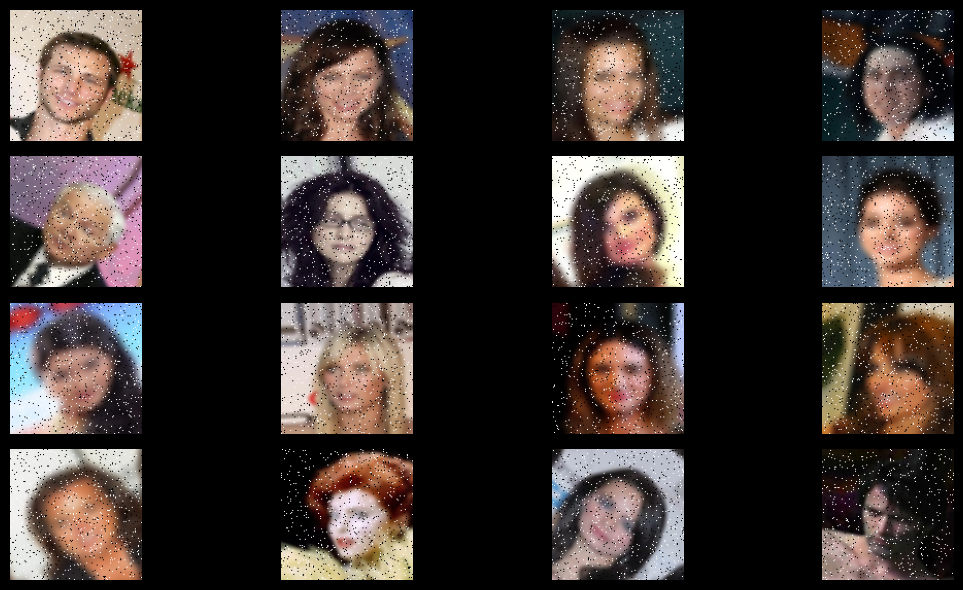

- Ground Truth images<br>
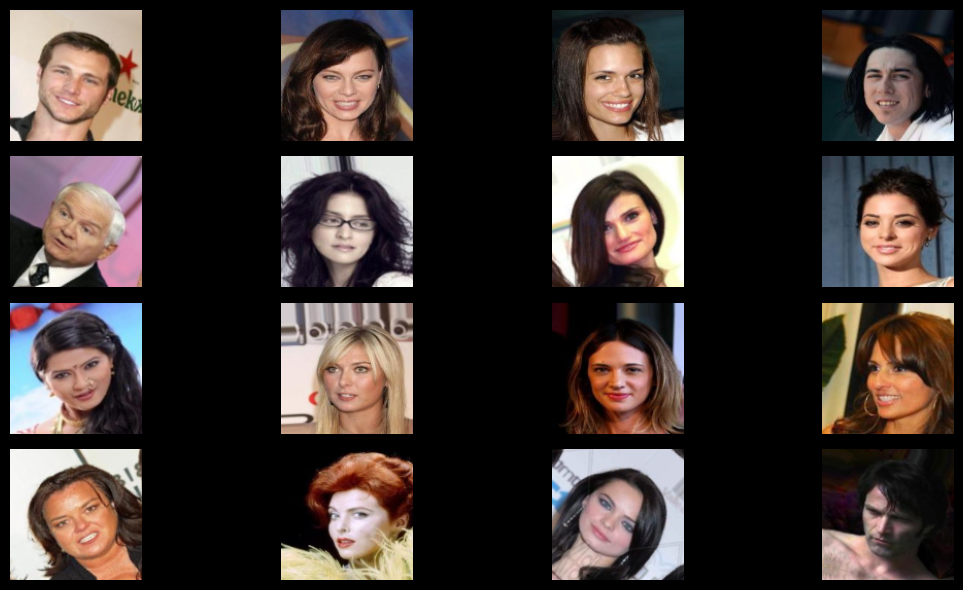

</details>

Complete the function below

In [ ]:
### START CODE HERE ###
def imshow_grid(images):
    pass
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
data_dir = None
dataset = CustomImageDataset(None
                            )
dataloader = DataLoader(dataset, batch_size=None)
### END CODE HERE ###

In [ ]:
### START CODE HERE ###
batch,gt_img = next(iter(dataloader)) 



### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model based on the provided code below. However, please maintain the concept of 'Autoencoder'.
[Read more.](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html)

In [ ]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_in = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.down1 = DownSamplingBlock(64, 128, kernel_size=3, stride=1, padding=1)
        ### DESIGN YOUR OWN MODEL ###
        self.up4 = UpSamplingBlock(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv_in(x)
        x = self.down1(x)

        x = self.up4(x)
        x = self.conv(x)
        return x
### END CODE HERE ###

If you define your model class correcly, the cell below should run without any errors.

In [ ]:
model = Autoencoder()
print(model)
out = model(batch[0].unsqueeze(dim=0).float())

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [ ]:
### START CODE HERE ###
def train(model,opt,loss_fn,train_loader,test_loader,epochs=10,checkpoint_path=None,device='cpu'):
    print("🤖Training on", device)
    model = model.to(device)
    for epoch in range(epochs):
        
        model.train()
        train_bar = tqdm(train_loader,desc=f'🚀Training Epoch [{epoch+1}/{epochs}]',unit='batch')
        for images, gt in train_bar:
            pass
            
        model.eval()
        test_bar = tqdm(test_loader,desc='📄Testing',unit='batch')
        for images, gt in test_bar:
            pass
                
### END CODE HERE ###

Let's train your model.

In [ ]:
### START CODE HERE ###

data_dir = None

files = os.listdir(data_dir)
files = [os.path.join(data_dir, file) for file in files]

# Split the dataset into training and testing sets
train_files, test_files = train_test_split(None)


train_dataset = CustomImageDataset(None)
test_dataset = CustomImageDataset(None)
trainloader = DataLoader(None)
testloader = DataLoader(None)
### END CODE HERE ###

In [ ]:
### START CODE HERE ###

model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
train(None)
### END CODE HERE ###

Let's use your trained model.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

- Input images<br>
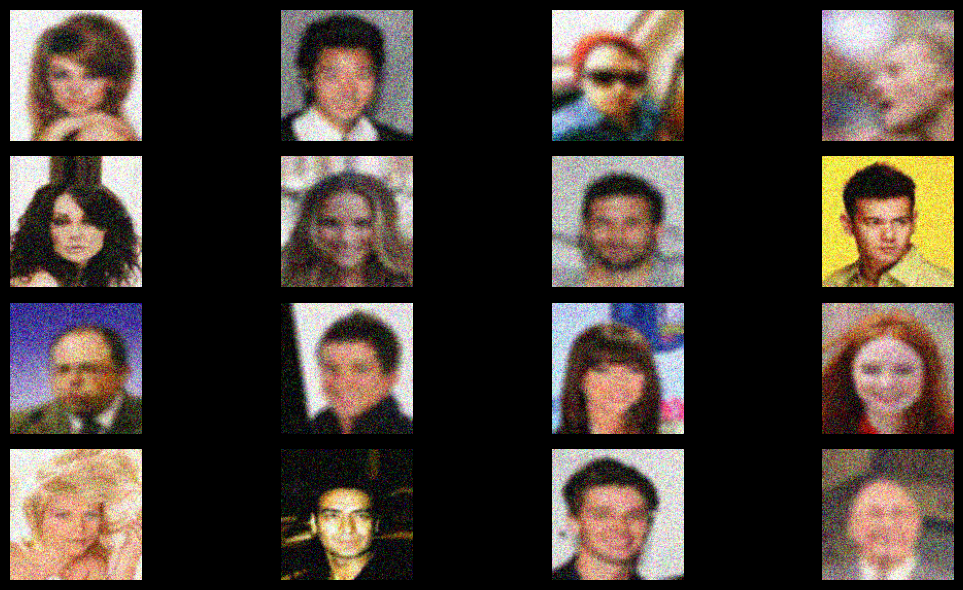

- Output images<br>
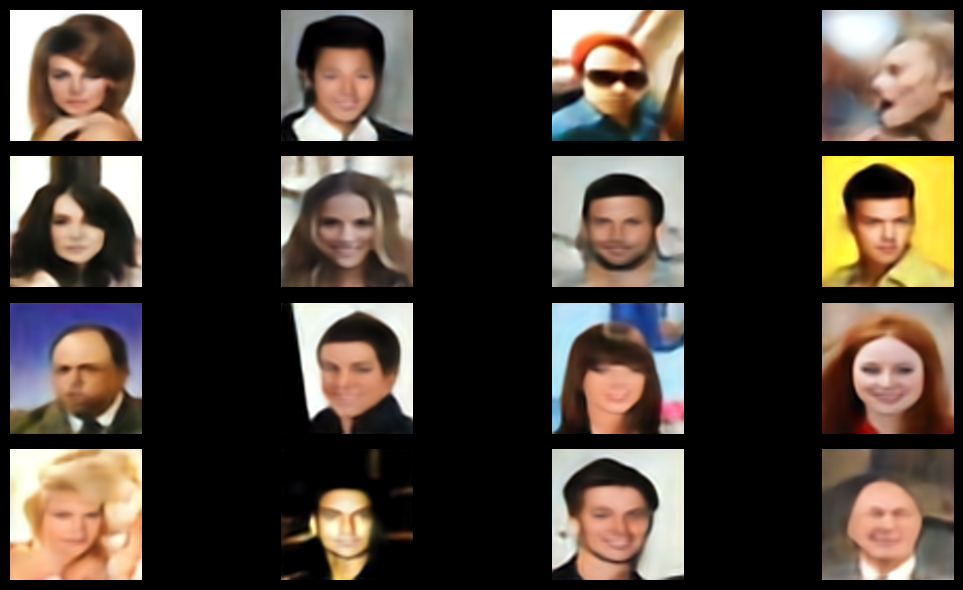

- Ground Truth images<br>
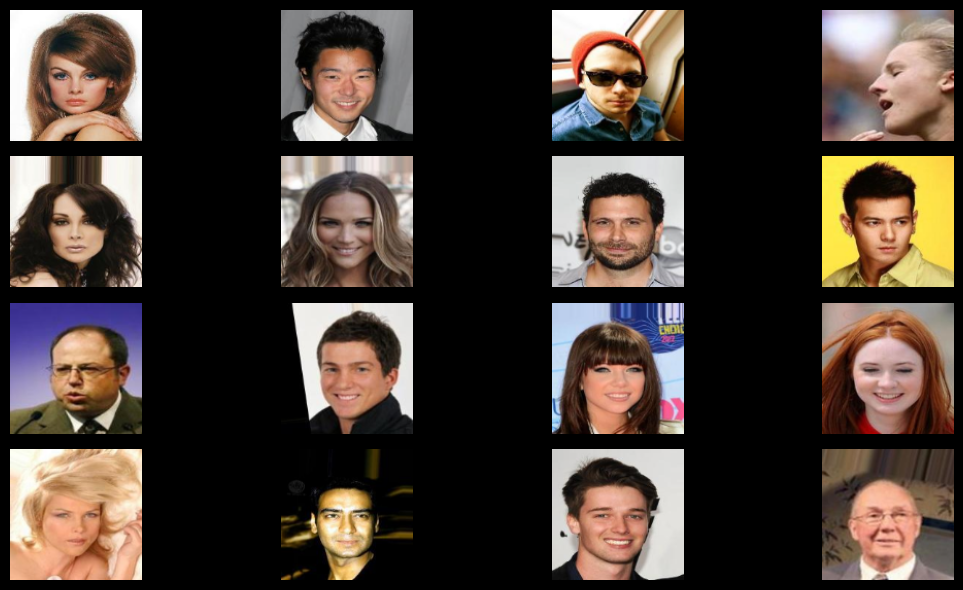

</details>

In [ ]:
### START CODE HERE ###


### END CODE HERE ###

## Explore feature map
Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers or block of your model. Then, save it as an image.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

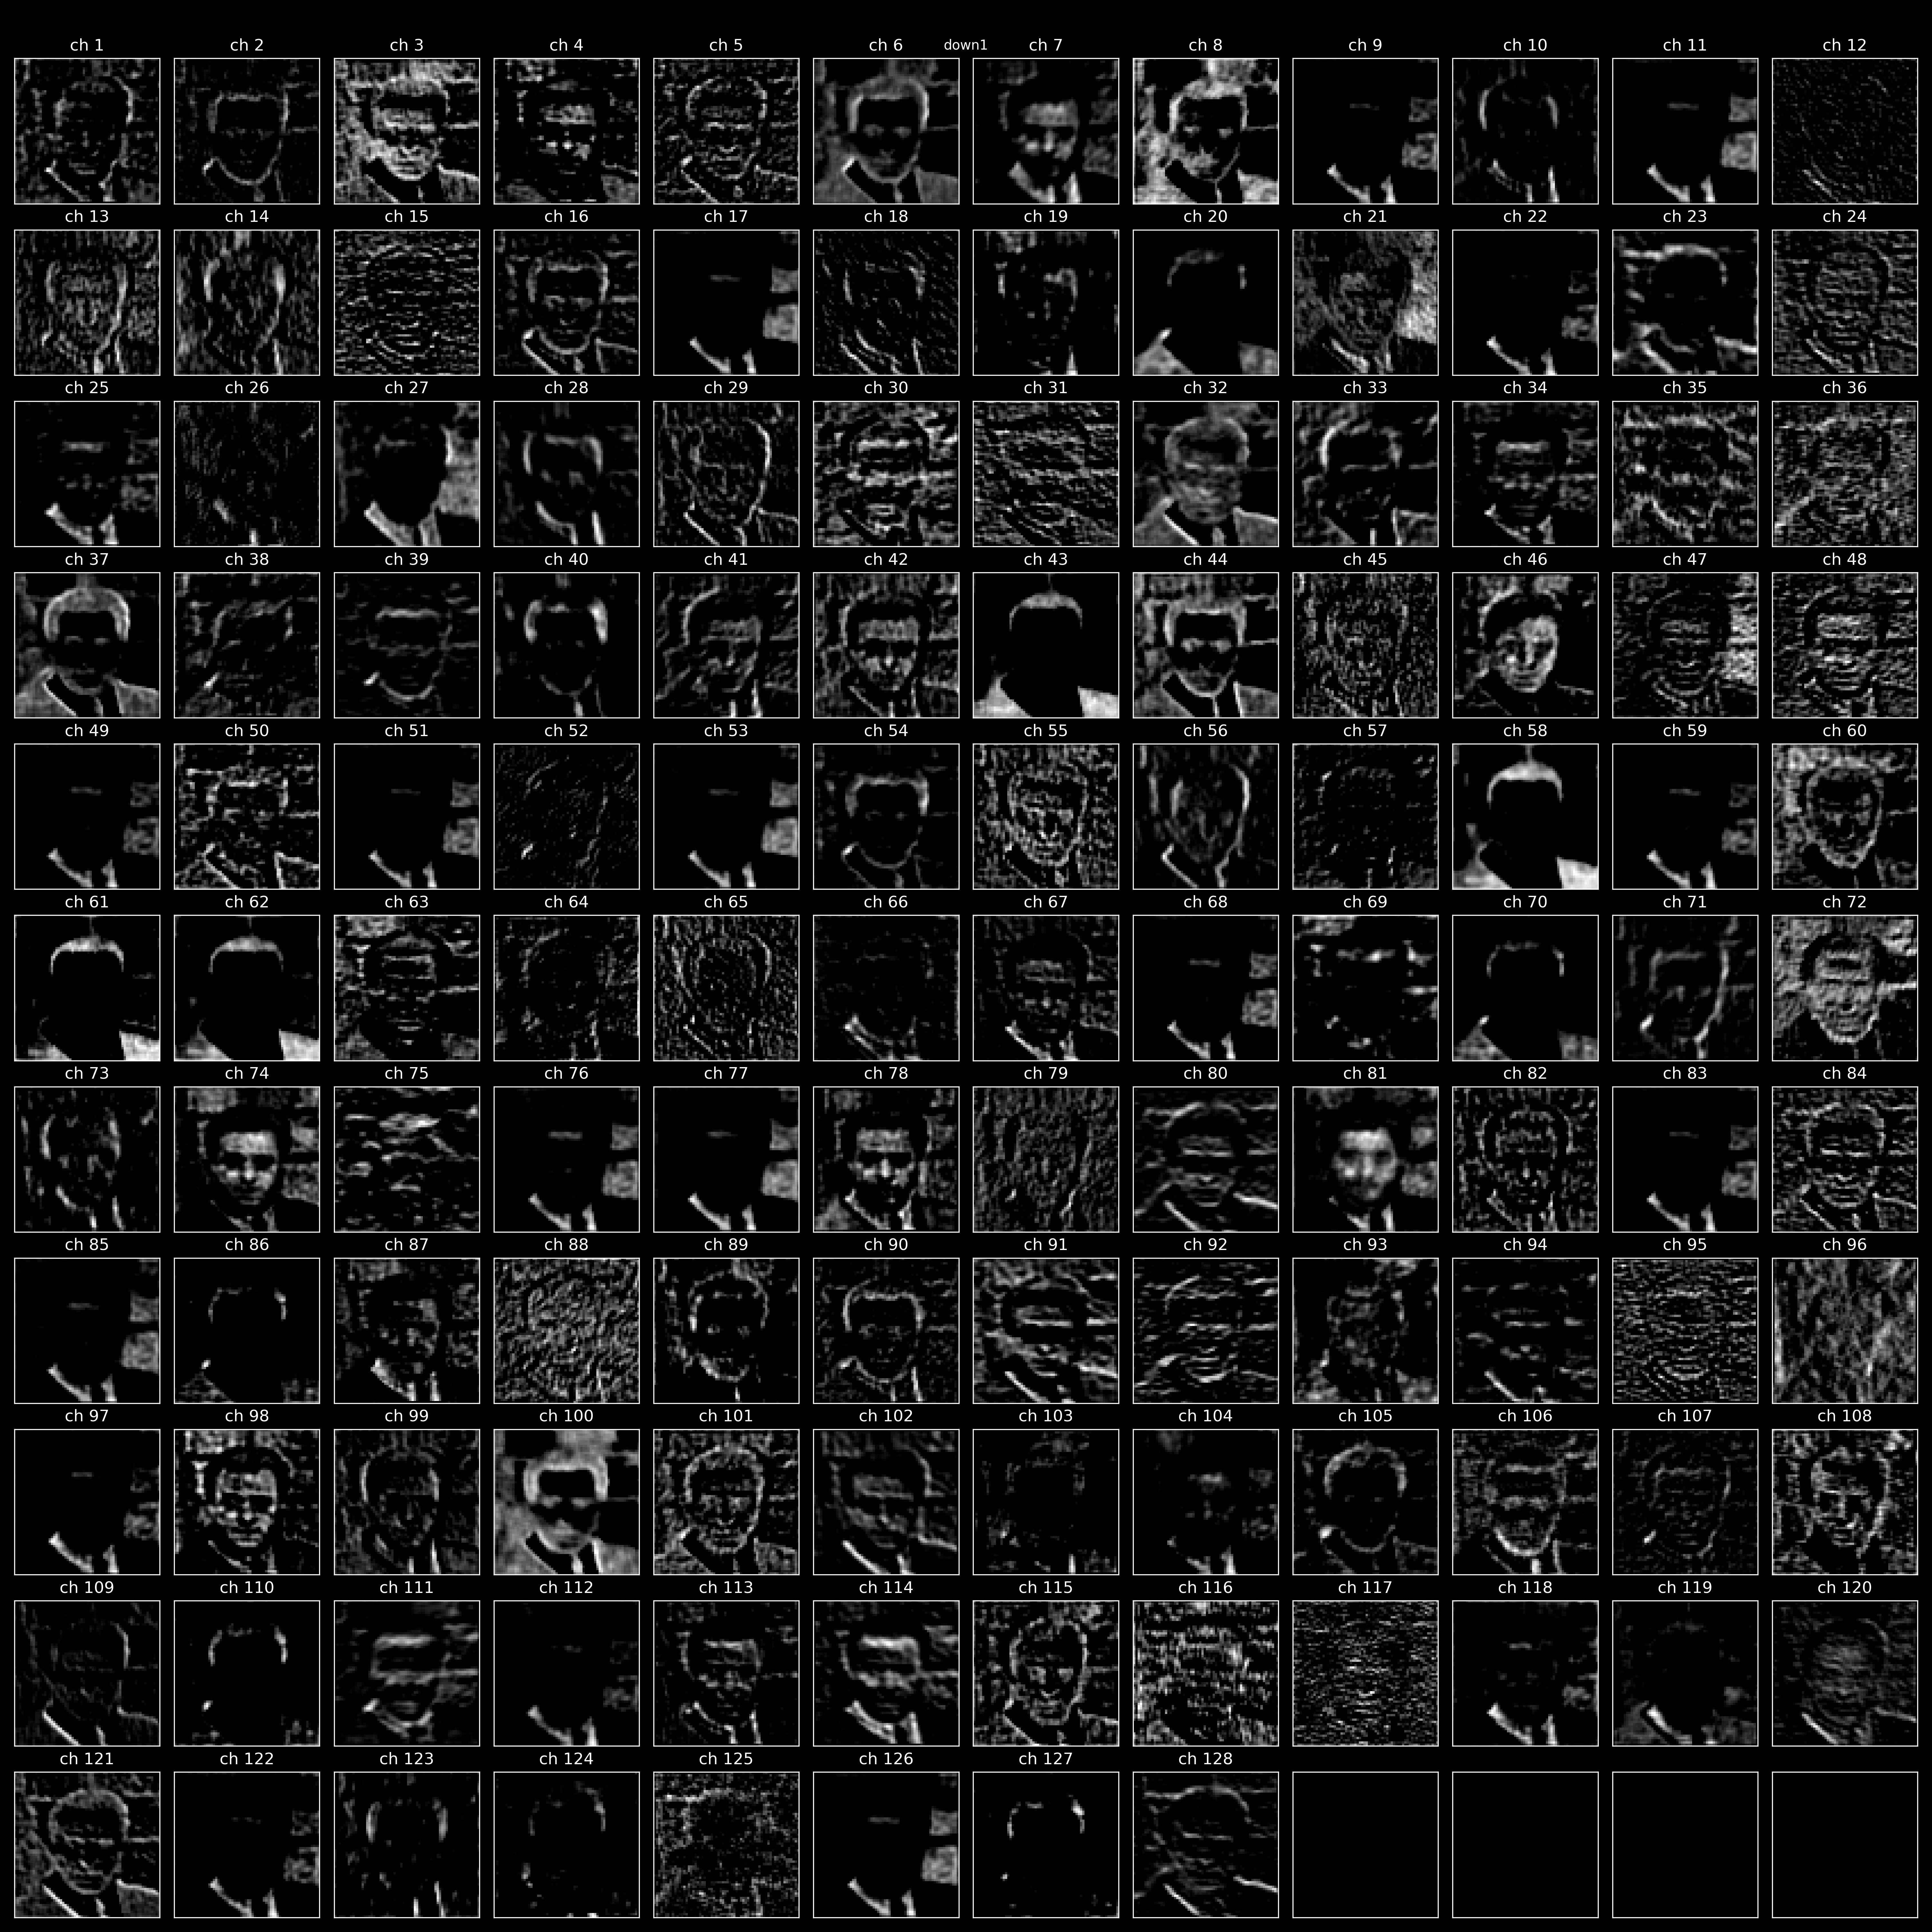
</details>

In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

In [ ]:
### START CODE HERE ###
def visualize_feature_map(x,base_filename):
    
    pass
### END CODE HERE ###


In [ ]:
### START CODE HERE ###




### END CODE HERE ###

---

# Questions:
1. Explain how changing the number of layers and the number of nodes in a Convolutional Neural Network (CNN) affects its performance (model accuracy, training time, and generalization/overfitting?  
2. Explain a comparison of PSNR and SSIM values (objective measurment) to your eye perception (subjective measurement) and suggest the criteria for High, Medium, Low image quality.
3. Explain a comparison of the autoencoder results between training without/with augmentation by visualizing feature maps at each layer.
4. Ranking the autoencoder performance in terms of PSNR and SSIM for each augmentation technique. Which augmentation techiques are mostly affect the autoencoder performance and must introduce to the training?
5. If a flatten layer is added after the last downsampling block to create the latent code (1D) and a dense layer ((linear + activation node)+ reshape back to the feature map size of input of the first upsampling block ) is added at the first layer of decoder before the first upsampling block. Explain a comparison of autoencoder results between 2D vs 1D latent and how feature map of each decoder block changes?
6. Explain the effect of reduced latent code from 2D to 1D.